#YOLO INFERENCE(추론용)

## 환경설정

In [ ]:
# 1단계: 환경 설정
print("🔍 YOLOv8 토마토 질병 분류 - 추론 노트북")
print("=" * 50)


# requiremenst 있을 때 제거
# 필요한 패키지 설치
print("📦 필요한 패키지 설치 중...")
!pip install ultralytics -q
print("✅ ultralytics 설치 완료")

# 라이브러리 import
import torch
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from google.colab import drive

# 구글 드라이브 마운트
print("\n📁 구글 드라이브 마운트 중...")
drive.mount('/content/drive', force_remount=True)
print("✅ 구글 드라이브 마운트 완료")

# GPU 확인
print(f"\n💻 시스템 정보:")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


🔍 YOLOv8 토마토 질병 분류 - 추론 노트북
📦 필요한 패키지 설치 중...
✅ ultralytics 설치 완료
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

📁 구글 드라이브 마운트 중...
Mounted at /content/drive
✅ 구글 드라이브 마운트 완료

💻 시스템 정보:
CUDA 사용 가능: True
GPU: Tesla T4
GPU 메모리: 14.7 GB


## 학습된 모델 로딩

In [ ]:
# 2단계: 학습된 모델 로딩
print(f"\n=== 학습된 모델 로딩 ===")

# 모델 경로 설정
model_path = '/content/drive/MyDrive/yolo_training_results/tomato_6class_v1/weights/best.pt'

# 모델 존재 확인
if os.path.exists(model_path):
    print(f"✅ 모델 파일 발견: {model_path}")
    model = YOLO(model_path)
    print("✅ 학습된 모델 로딩 완료")

    # 모델 정보 확인
    print(f"\n=== 모델 정보 ===")
    print(f"클래스 개수: {len(model.names)}")
    print(f"클래스 목록: {list(model.names.values())}")

    # 클래스 이름 한국어 매핑
    class_names_kr = ['정상', '토마토잿빛곰팡이병', '토마토흰가루병',
                      '다량원소결핍(N)', '다량원소결핍(P)', '다량원소결핍(K)']
    print(f"한국어 클래스명: {class_names_kr}")
else:
    print(f"❌ 모델 파일이 없습니다: {model_path}")
    print("⚠️ 학습을 먼저 완료해주세요!")
    model = None

# GPU 설정 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"사용 디바이스: {device}")



=== 학습된 모델 로딩 ===
✅ 모델 파일 발견: /content/drive/MyDrive/yolo_training_results/tomato_6class_v1/weights/best.pt
✅ 학습된 모델 로딩 완료

=== 모델 정보 ===
클래스 개수: 6
클래스 목록: ['정상', '토마토잿빛곰팡이병', '토마토흰가루병', '다량원소결핍(N)', '다량원소결핍(P)', '다량원소결핍(K)']
한국어 클래스명: ['정상', '토마토잿빛곰팡이병', '토마토흰가루병', '다량원소결핍(N)', '다량원소결핍(P)', '다량원소결핍(K)']
사용 디바이스: cuda


## 모델 학습 품질 분석

In [ ]:
# 2.5단계: 학습 품질 분석
import pandas as pd

def analyze_model_quality():
    """학습된 모델의 품질 분석 - 추론 전 모델 검증용"""
    print(f"\n=== 학습된 모델 품질 분석 ===")

    results_dir = '/content/drive/MyDrive/yolo_training_results/tomato_6class_v1'
    results_csv = f"{results_dir}/results.csv"

    if not os.path.exists(results_csv):
        print(f"❌ 학습 결과 파일이 없습니다: {results_csv}")
        print(f"💡 이 분석은 학습이 완료된 후에만 가능합니다.")
        return None

    print(f"✅ 학습 결과 분석 시작")

    # CSV 읽기
    df = pd.read_csv(results_csv)
    print(f"총 학습 에포크: {len(df)}개")

    # mAP 분석
    map50_col = None
    if 'metrics/mAP50(B)' in df.columns:
        map50_col = 'metrics/mAP50(B)'
    elif 'val/mAP50' in df.columns:
        map50_col = 'val/mAP50'

    if map50_col:
        map50_values = df[map50_col].values
        best_map50 = max(map50_values)
        best_epoch = df[df[map50_col] == best_map50].index[0] + 1
        final_map50 = map50_values[-1]

        print(f"\n📊 모델 성능 요약:")
        print(f"  최고 mAP50: {best_map50:.4f} (에포크 {best_epoch})")
        print(f"  최종 mAP50: {final_map50:.4f}")
        print(f"  성능 차이: {(best_map50 - final_map50):.4f}")

        # 모델 품질 판정
        if final_map50 > 0.9:
            quality = "🏆 매우 우수 (90%+)"
        elif final_map50 > 0.8:
            quality = "✅ 우수 (80-90%)"
        elif final_map50 > 0.7:
            quality = "🔶 양호 (70-80%)"
        elif final_map50 > 0.6:
            quality = "⚠️ 보통 (60-70%)"
        else:
            quality = "❌ 개선 필요 (<60%)"

        print(f"  모델 품질: {quality}")

        # 과적합 검사
        performance_drop = best_map50 - final_map50
        if performance_drop > 0.02:
            print(f"  ⚠️ 과적합 의심: 최고 성능 대비 {performance_drop:.1%} 하락")
            print(f"  💡 권장: best.pt 모델 사용 (에포크 {best_epoch})")
        else:
            print(f"  ✅ 안정적: 과적합 문제 없음")

        return {
            'best_map50': best_map50,
            'best_epoch': best_epoch,
            'final_map50': final_map50,
            'quality_score': final_map50,
            'overfitting_risk': performance_drop > 0.02
        }
    else:
        print(f"❌ mAP 데이터를 찾을 수 없습니다.")
        return None

def plot_quick_training_summary():
    """전문적인 학습 곡선 표시 - 3개 그래프로 구성"""
    print(f"\n=== 학습 곡선 요약 ===")

    results_csv = '/content/drive/MyDrive/yolo_training_results/tomato_6class_v1/results.csv'

    if not os.path.exists(results_csv):
        print(f"❌ 학습 결과 파일이 없습니다.")
        return

    df = pd.read_csv(results_csv)

    # 스타일 설정
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Results Summary', fontsize=16, fontweight='bold')

    # 1. mAP50 진행
    if 'metrics/mAP50(B)' in df.columns:
        ax1 = axes[0, 0]
        epochs = range(len(df))
        ax1.plot(epochs, df['metrics/mAP50(B)'], color='#1f77b4', linewidth=2, label='mAP50')
        ax1.set_title('mAP50 진행', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('mAP50')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # 최고점 표시
        best_idx = df['metrics/mAP50(B)'].idxmax()
        best_value = df['metrics/mAP50(B)'].iloc[best_idx]
        ax1.plot(best_idx, best_value, 'ro', markersize=8, label=f'Best: {best_value:.3f}')
        ax1.legend()

        # Y축 범위 조정
        ax1.set_ylim([0, max(1.0, df['metrics/mAP50(B)'].max() * 1.1)])

    # 2. mAP50-95 진행
    if 'metrics/mAP50-95(B)' in df.columns:
        ax2 = axes[0, 1]
        ax2.plot(epochs, df['metrics/mAP50-95(B)'], color='#2ca02c', linewidth=2, label='mAP50-95')
        ax2.set_title('mAP50-95 진행', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('mAP50-95')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        # Y축 범위 조정
        ax2.set_ylim([0, max(1.0, df['metrics/mAP50-95(B)'].max() * 1.1)])

    # 3. Loss 진행 (Train vs Val)
    ax3 = axes[1, 0]

    # Loss 컬럼 찾기
    train_loss_cols = [col for col in df.columns if 'train' in col and 'loss' in col]
    val_loss_cols = [col for col in df.columns if 'val' in col and 'loss' in col]

    if train_loss_cols and val_loss_cols:
        train_loss_col = train_loss_cols[0]  # 첫 번째 train loss 사용
        val_loss_col = val_loss_cols[0]      # 첫 번째 val loss 사용

        ax3.plot(epochs, df[train_loss_col], color='#d62728', linewidth=2, label='Train Loss')
        ax3.plot(epochs, df[val_loss_col], color='#ff7f0e', linewidth=2, label='Val Loss')

        ax3.set_title('Loss 진행', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Loss')
        ax3.grid(True, alpha=0.3)
        ax3.legend()

        # Y축 범위 조정
        max_loss = max(df[train_loss_col].max(), df[val_loss_col].max())
        ax3.set_ylim([0, max_loss * 1.1])
    else:
        # Loss 데이터가 없으면 다른 메트릭 표시
        ax3.text(0.5, 0.5, 'Loss 데이터 없음', transform=ax3.transAxes,
                ha='center', va='center', fontsize=12)
        ax3.set_title('Loss 진행', fontsize=14, fontweight='bold')

    # 4. 최근 성능 상세 (최근 10 에포크)
    ax4 = axes[1, 1]
    recent_epochs = min(10, len(df))

    if 'metrics/mAP50(B)' in df.columns:
        recent_data = df['metrics/mAP50(B)'].tail(recent_epochs)
        recent_x = range(len(df) - recent_epochs, len(df))

        ax4.plot(recent_x, recent_data, 'o-', color='#9467bd', linewidth=2,
                markersize=6, label=f'Recent {recent_epochs} epochs')
        ax4.set_title(f'최근 {recent_epochs} 에포크 상세', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('mAP50')
        ax4.grid(True, alpha=0.3)
        ax4.legend()

        # 최종 값 표시
        final_value = recent_data.iloc[-1]
        ax4.annotate(f'Final: {final_value:.3f}',
                    xy=(recent_x[-1], final_value),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/comprehensive_training_summary.png',
                dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

    # 성능 요약 출력
    if 'metrics/mAP50(B)' in df.columns:
        print(f"\n📊 성능 요약:")
        print(f"  최고 mAP50: {df['metrics/mAP50(B)'].max():.4f}")
        print(f"  최종 mAP50: {df['metrics/mAP50(B)'].iloc[-1]:.4f}")
        print(f"  총 에포크: {len(df)}개")

        if 'metrics/mAP50-95(B)' in df.columns:
            print(f"  최고 mAP50-95: {df['metrics/mAP50-95(B)'].max():.4f}")
            print(f"  최종 mAP50-95: {df['metrics/mAP50-95(B)'].iloc[-1]:.4f}")

    print(f"📈 상세 학습 곡선 저장: /content/drive/MyDrive/comprehensive_training_summary.png")

# 사용 안내
print(f"\n💡 모델 품질 확인 함수:")
print(f"  - analyze_model_quality()        # 모델 품질 분석")
print(f"  - plot_quick_training_summary()  # 학습 곡선 요약")
print(f"  ⏰ 선택적 실행: 추론 전 모델 검증용")



💡 모델 품질 확인 함수:
  - analyze_model_quality()        # 모델 품질 분석
  - plot_quick_training_summary()  # 학습 곡선 요약
  ⏰ 선택적 실행: 추론 전 모델 검증용


In [ ]:
# 모델 품질 분석
analyze_model_quality()


=== 학습된 모델 품질 분석 ===
✅ 학습 결과 분석 시작
총 학습 에포크: 25개

📊 모델 성능 요약:
  최고 mAP50: 0.9477 (에포크 23)
  최종 mAP50: 0.9428
  성능 차이: 0.0049
  모델 품질: 🏆 매우 우수 (90%+)
  ✅ 안정적: 과적합 문제 없음


{'best_map50': np.float64(0.94772),
 'best_epoch': np.int64(23),
 'final_map50': np.float64(0.94281),
 'quality_score': np.float64(0.94281),
 'overfitting_risk': np.False_}


=== 학습 곡선 요약 ===


/tmp/ipython-input-2450784617.py:176: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2450784617.py:176: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2450784617.py:176: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2450784617.py:176: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2450784617.py:176: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2450784617.py:176: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2450784617.py:176: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_l

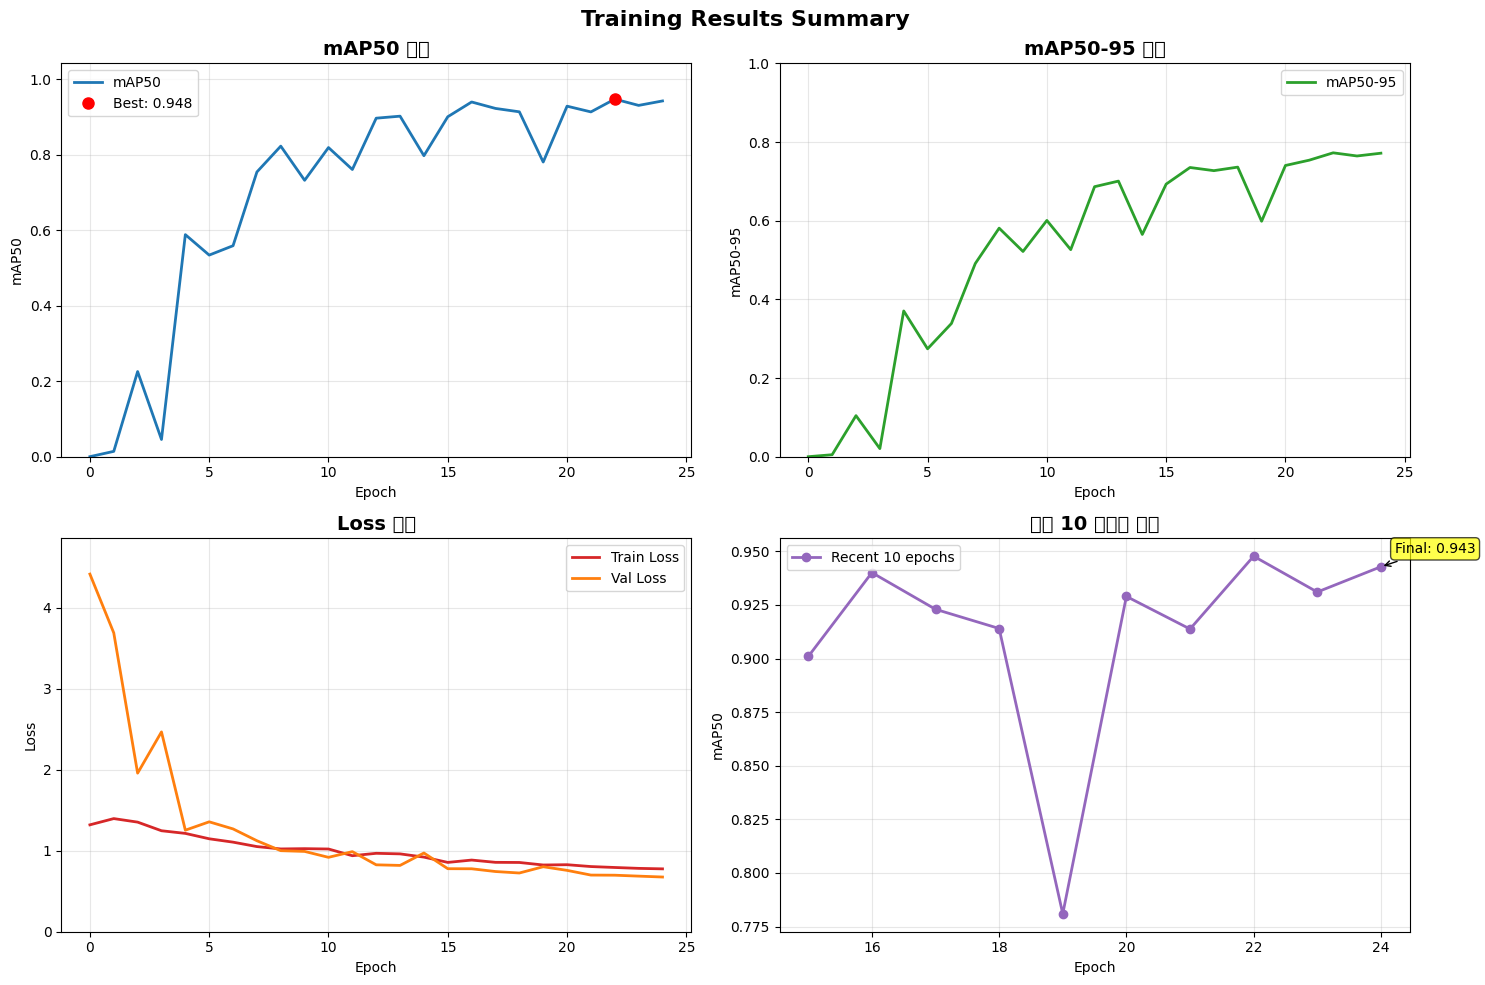


📊 성능 요약:
  최고 mAP50: 0.9477
  최종 mAP50: 0.9428
  총 에포크: 25개
  최고 mAP50-95: 0.7725
  최종 mAP50-95: 0.7716
📈 상세 학습 곡선 저장: /content/drive/MyDrive/comprehensive_training_summary.png


In [ ]:
# 학습 곡선 요약
plot_quick_training_summary()

📊 학습 곡선 그래프 상세 설명

**1. mAP50 (왼쪽 위)**

📌 의미: 객체 탐지 정확도 (IoU ≥ 0.5 기준)

Y축: 0~1 범위 (1에 가까울수록 좋음)

현재 성능: 최고 0.948 (94.8%) - 매우 우수!

추세: 초기 급상승 → 안정화 → 약간의 변동

빨간 점: 최고 성능 지점 (에포크 22)

🔍 분석:

에포크 0-5: 급격한 성능 향상

에포크 5-15: 점진적 상승 및 안정화

에포크 15-24: 미세 조정 단계


**2. mAP50-95** (오른쪽 위)

📌 의미: 더 엄격한 정확도 (IoU 0.5~0.95 평균)

현재 성능: 약 0.78 (78%) - 우수한 편

mAP50 vs mAP50-95: 0.948 vs 0.78

차이 원인: 높은 IoU 기준에서는 정확도 하락

🔍 분석:

mAP50보다 낮은 것은 정상 (더 엄격한 기준)

꾸준한 상승 추세 유지

78%면 실제 응용에서 충분히 사용 가능

**3. Loss 진행** (왼쪽 아래)

📌 의미: 학습 과정에서 오류 감소 추이

🔴 Train Loss (빨간선):

시작: ~1.4 → 최종: ~0.7

꾸준히 감소하며 안정화

🟠 Val Loss (주황선):

시작: ~4.5 → 최종: ~0.7

초기 급격 감소 후 Train Loss와 수렴

🔍 과적합 분석:

✅ 과적합 없음: Train/Val Loss가 비슷하게 수렴

✅ 안정적 학습: 발산 없이 꾸준히 감소

**4. 최근 10 에포크 상세** (오른쪽 아래)

📌 의미: 학습 마지막 단계 미세 변화 관찰

보라색 선 분석:

Y축: 0.775~0.950 (확대된 스케일)

에포크 18에서 일시적 하락 → 회복

Final: 0.943 (노란 박스) - 최종 성능

🔍 최종 판단:

마지막까지 성능 유지

약간의 변동은 정상 (미세 조정)

0.943은 매우 높은 최종 성능

## 단일 이미지 추론 함수

In [ ]:
# 3단계: 단일 이미지 추론 함수
def test_inference(image_path=None, confidence=0.25, show_image=True):
    """학습된 모델로 단일 이미지 추론 테스트"""

    if model is None:
        print("❌ 모델이 로드되지 않았습니다.")
        return None

    print(f"\n🔍 단일 이미지 추론 테스트 (confidence={confidence})")

    # 테스트 이미지 선택
    if image_path is None:
        # validation 데이터에서 랜덤 선택
        val_dir = "/content/drive/MyDrive/dataset_6class_complete/newpart_03"

        if os.path.exists(val_dir):
            val_images = [f for f in os.listdir(val_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if val_images:
                selected_image = random.choice(val_images)
                image_path = f"{val_dir}/{selected_image}"
                print(f"📷 랜덤 선택된 테스트 이미지: {selected_image}")
            else:
                print(f"❌ validation 이미지가 없습니다.")
                return None
        else:
            print(f"❌ validation 디렉토리가 없습니다: {val_dir}")
            return None

    print(f"🖼️ 테스트 이미지: {os.path.basename(image_path)}")

    # 추론 실행
    print(f"🚀 추론 실행 중...")
    results = model(image_path, conf=confidence, device=0, verbose=False)

    # 결과 분석
    result = results[0]

    print(f"\n📊 추론 결과:")

    if result.boxes is not None and len(result.boxes) > 0:
        print(f"✅ {len(result.boxes)}개 객체 검출:")

        for i, box in enumerate(result.boxes):
            class_id = int(box.cls[0])
            confidence_score = float(box.conf[0])
            class_name = class_names_kr[class_id]

            # 바운딩 박스 좌표
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

            print(f"  {i+1}. {class_name}")
            print(f"     신뢰도: {confidence_score:.3f}")
            print(f"     박스: ({x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f})")
    else:
        print(f"❌ 검출된 객체 없음 (confidence={confidence} 기준)")
        print(f"💡 더 낮은 confidence로 다시 시도해보세요:")
        print(f"   test_inference(confidence=0.1)")

    # 결과 이미지 시각화
    if show_image:
        plotted = result.plot()  # 결과 시각화

        if plotted is not None:
            # OpenCV BGR -> RGB 변환
            plotted_rgb = plotted[:, :, ::-1]

            # 결과 이미지 저장
            result_save_path = '/content/drive/MyDrive/inference_result.jpg'
            pil_image = Image.fromarray(plotted_rgb)
            pil_image.save(result_save_path)
            print(f"💾 결과 이미지 저장: {result_save_path}")

            # 이미지 표시
            plt.figure(figsize=(12, 8))
            plt.imshow(plotted_rgb)
            plt.axis('off')
            plt.title(f'YOLOv8 Inference Result - {os.path.basename(image_path)}', fontsize=16)
            plt.tight_layout()

            display_save_path = '/content/drive/MyDrive/inference_display.png'
            plt.savefig(display_save_path, dpi=150, bbox_inches='tight')
            plt.show()
            print(f"📈 표시 결과 저장: {display_save_path}")

    return results


🔍 단일 이미지 추론 테스트 (confidence=0.25)
📷 랜덤 선택된 테스트 이미지: class0_020.jpg
🖼️ 테스트 이미지: class0_020.jpg
🚀 추론 실행 중...

📊 추론 결과:
✅ 1개 객체 검출:
  1. 정상
     신뢰도: 0.778
     박스: (137, 286, 2367, 4032)
💾 결과 이미지 저장: /content/drive/MyDrive/inference_result.jpg


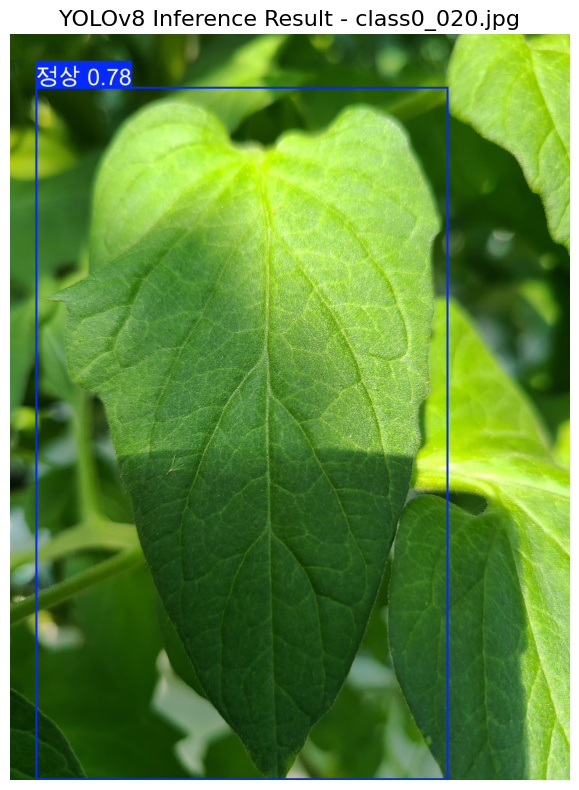

📈 표시 결과 저장: /content/drive/MyDrive/inference_display.png


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '정상', 1: '토마토잿빛곰팡이병', 2: '토마토흰가루병', 3: '다량원소결핍(N)', 4: '다량원소결핍(P)', 5: '다량원소결핍(K)'}
 obb: None
 orig_img: array([[[  6,  76,  36],
         [  5,  75,  35],
         [  1,  72,  32],
         ...,
         [ 54, 209, 164],
         [ 51, 208, 164],
         [ 56, 213, 169]],
 
        [[ 11,  81,  41],
         [ 13,  83,  43],
         [  7,  77,  37],
         ...,
         [ 54, 209, 164],
         [ 50, 207, 163],
         [ 54, 211, 167]],
 
        [[  2,  68,  27],
         [  5,  73,  32],
         [  0,  71,  31],
         ...,
         [ 54, 211, 167],
         [ 52, 209, 165],
         [ 54, 211, 167]],
 
        ...,
 
        [[  2,  60,  12],
         [  5,  60,  13],
         [  8,  63,  18],
         ...,
         [ 56, 194, 136],
         [ 57, 197, 138],
         [ 61, 201, 142]],
 
        [[  4,  59,  14],
         [

In [ ]:
test_inference()

## 다중 이미지 추론 함수

In [ ]:
# 4단계: 다중 이미지 추론 함수
def test_multiple_images(num_images=5, confidence=0.25, show_summary=True):
    """여러 이미지로 추론 테스트 및 정확도 분석"""

    if model is None:
        print("❌ 모델이 로드되지 않았습니다.")
        return None

    print(f"\n🔍 {num_images}개 이미지 추론 테스트!")

    # validation 이미지들
    val_dir = "/content/drive/MyDrive/dataset_6class_complete/newpart_03"

    if not os.path.exists(val_dir):
        print(f"❌ validation 디렉토리가 없습니다: {val_dir}")
        return None

    val_images = [f for f in os.listdir(val_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if len(val_images) == 0:
        print("❌ validation 이미지가 없습니다.")
        return None

    # 랜덤 선택
    selected_images = random.sample(val_images, min(num_images, len(val_images)))

    print(f"\n📊 {len(selected_images)}개 이미지 테스트 결과:")

    detection_summary = {}
    results_data = []

    for i, img_name in enumerate(selected_images):
        img_path = f"{val_dir}/{img_name}"

        # 실제 클래스 (파일명에서 추출 시도)
        true_class_name = "Unknown"
        true_class = -1

        if img_name.startswith('class'):
            try:
                true_class = int(img_name.split('_')[0].replace('class', ''))
                true_class_name = class_names_kr[true_class]
            except:
                pass

        print(f"\n{i+1}. {img_name}")
        print(f"   실제 클래스: {true_class_name}")

        # 추론 실행
        results = model(img_path, conf=confidence, device=0, verbose=False)
        result = results[0]

        pred_class_name = "검출 없음"
        pred_confidence = 0.0
        is_correct = False

        if result.boxes is not None and len(result.boxes) > 0:
            # 가장 높은 신뢰도의 예측
            best_box = result.boxes[0]
            pred_class = int(best_box.cls[0])
            pred_confidence = float(best_box.conf[0])
            pred_class_name = class_names_kr[pred_class]

            print(f"   예측 클래스: {pred_class_name} (신뢰도: {pred_confidence:.3f})")

            # 정확도 체크
            if true_class != -1:
                is_correct = (pred_class == true_class)
                print(f"   정확도: {'✅ 맞음' if is_correct else '❌ 틀림'}")

                # 통계 수집
                if true_class_name not in detection_summary:
                    detection_summary[true_class_name] = {'correct': 0, 'total': 0}
                detection_summary[true_class_name]['total'] += 1
                if is_correct:
                    detection_summary[true_class_name]['correct'] += 1
        else:
            print(f"   예측 클래스: 검출 없음")

        # 결과 데이터 저장
        results_data.append({
            'image': img_name,
            'true_class': true_class_name,
            'pred_class': pred_class_name,
            'confidence': pred_confidence,
            'correct': is_correct
        })

    # 전체 요약 출력
    if show_summary and detection_summary:
        print(f"\n📈 클래스별 정확도 요약:")
        overall_correct = 0
        overall_total = 0

        for class_name, stats in detection_summary.items():
            accuracy = stats['correct'] / stats['total'] * 100
            print(f"  {class_name}: {stats['correct']}/{stats['total']} = {accuracy:.1f}%")
            overall_correct += stats['correct']
            overall_total += stats['total']

        overall_accuracy = overall_correct / overall_total * 100
        print(f"\n🎯 전체 정확도: {overall_correct}/{overall_total} = {overall_accuracy:.1f}%")

    return results_data

In [ ]:
test_multiple_images(num_images=10)


🔍 10개 이미지 추론 테스트!

📊 10개 이미지 테스트 결과:

1. class2_046.jpg
   실제 클래스: 토마토흰가루병
   예측 클래스: 토마토흰가루병 (신뢰도: 0.824)
   정확도: ✅ 맞음

2. class0_024.jpg
   실제 클래스: 정상
   예측 클래스: 정상 (신뢰도: 0.719)
   정확도: ✅ 맞음

3. class5_007.jpg
   실제 클래스: 다량원소결핍(K)
   예측 클래스: 다량원소결핍(K) (신뢰도: 0.865)
   정확도: ✅ 맞음

4. class3_042.jpg
   실제 클래스: 다량원소결핍(N)
   예측 클래스: 다량원소결핍(N) (신뢰도: 0.723)
   정확도: ✅ 맞음

5. class5_010.jpg
   실제 클래스: 다량원소결핍(K)
   예측 클래스: 다량원소결핍(K) (신뢰도: 0.772)
   정확도: ✅ 맞음

6. class0_015.jpg
   실제 클래스: 정상
   예측 클래스: 정상 (신뢰도: 0.804)
   정확도: ✅ 맞음

7. class2_048.jpg
   실제 클래스: 토마토흰가루병
   예측 클래스: 토마토흰가루병 (신뢰도: 0.854)
   정확도: ✅ 맞음

8. class1_021.jpg
   실제 클래스: 토마토잿빛곰팡이병
   예측 클래스: 토마토잿빛곰팡이병 (신뢰도: 0.845)
   정확도: ✅ 맞음

9. class0_049.jpg
   실제 클래스: 정상
   예측 클래스: 정상 (신뢰도: 0.752)
   정확도: ✅ 맞음

10. class5_008.jpg
   실제 클래스: 다량원소결핍(K)
   예측 클래스: 다량원소결핍(K) (신뢰도: 0.708)
   정확도: ✅ 맞음

📈 클래스별 정확도 요약:
  토마토흰가루병: 2/2 = 100.0%
  정상: 3/3 = 100.0%
  다량원소결핍(K): 3/3 = 100.0%
  다량원소결핍(N): 1/1 = 100.0%
  토마토잿빛곰팡이병: 1/1 = 100.0%

🎯 전

[{'image': 'class2_046.jpg',
  'true_class': '토마토흰가루병',
  'pred_class': '토마토흰가루병',
  'confidence': 0.8235326409339905,
  'correct': True},
 {'image': 'class0_024.jpg',
  'true_class': '정상',
  'pred_class': '정상',
  'confidence': 0.7187407612800598,
  'correct': True},
 {'image': 'class5_007.jpg',
  'true_class': '다량원소결핍(K)',
  'pred_class': '다량원소결핍(K)',
  'confidence': 0.865148663520813,
  'correct': True},
 {'image': 'class3_042.jpg',
  'true_class': '다량원소결핍(N)',
  'pred_class': '다량원소결핍(N)',
  'confidence': 0.7229098081588745,
  'correct': True},
 {'image': 'class5_010.jpg',
  'true_class': '다량원소결핍(K)',
  'pred_class': '다량원소결핍(K)',
  'confidence': 0.771858274936676,
  'correct': True},
 {'image': 'class0_015.jpg',
  'true_class': '정상',
  'pred_class': '정상',
  'confidence': 0.8039379119873047,
  'correct': True},
 {'image': 'class2_048.jpg',
  'true_class': '토마토흰가루병',
  'pred_class': '토마토흰가루병',
  'confidence': 0.8541996479034424,
  'correct': True},
 {'image': 'class1_021.jpg',
  'true_

## 클래스별 성능 상세 테스트

In [ ]:
# 5단계: 클래스별 성능 상세 테스트
def test_class_performance(max_samples_per_class=10, confidence=0.25):
    """클래스별 성능 상세 테스트"""

    if model is None:
        print("❌ 모델이 로드되지 않았습니다.")
        return None

    print(f"\n🎯 클래스별 성능 상세 테스트!")

    val_dir = "/content/drive/MyDrive/dataset_6class_complete/newpart_03"

    if not os.path.exists(val_dir):
        print(f"❌ validation 디렉토리가 없습니다: {val_dir}")
        return None

    # 클래스별 파일 분류
    class_files = {i: [] for i in range(6)}

    for file in os.listdir(val_dir):
        if file.startswith('class') and file.endswith(('.jpg', '.jpeg', '.png')):
            try:
                class_id = int(file.split('_')[0].replace('class', ''))
                if 0 <= class_id <= 5:
                    class_files[class_id].append(file)
            except:
                continue

    print(f"\n📊 클래스별 상세 성능:")

    class_performance = {}

    for class_id, files in class_files.items():
        if not files:
            continue

        class_name = class_names_kr[class_id]
        print(f"\n🔍 {class_name} (클래스 {class_id}):")
        print(f"   사용 가능한 파일 수: {len(files)}개")

        # 테스트할 파일 선택
        test_files = files[:min(max_samples_per_class, len(files))]
        print(f"   테스트 파일 수: {len(test_files)}개")

        correct = 0
        total = len(test_files)
        confidences = []
        wrong_predictions = []

        for file in test_files:
            img_path = f"{val_dir}/{file}"
            results = model(img_path, conf=confidence, device=0, verbose=False)

            if results[0].boxes is not None and len(results[0].boxes) > 0:
                pred_class = int(results[0].boxes[0].cls[0])
                confidence_score = float(results[0].boxes[0].conf[0])

                if pred_class == class_id:
                    correct += 1
                else:
                    wrong_predictions.append({
                        'file': file,
                        'predicted': class_names_kr[pred_class],
                        'confidence': confidence_score
                    })

                confidences.append(confidence_score)

        accuracy = correct / total * 100 if total > 0 else 0
        avg_confidence = sum(confidences) / len(confidences) if confidences else 0

        print(f"   정확도: {correct}/{total} = {accuracy:.1f}%")
        print(f"   평균 신뢰도: {avg_confidence:.3f}")

        # 잘못 예측된 경우들 표시
        if wrong_predictions:
            print(f"   ❌ 잘못 예측된 경우들:")
            for wp in wrong_predictions[:3]:  # 최대 3개만 표시
                print(f"      {wp['file']} → {wp['predicted']} (신뢰도: {wp['confidence']:.3f})")

        class_performance[class_name] = {
            'accuracy': accuracy,
            'avg_confidence': avg_confidence,
            'correct': correct,
            'total': total,
            'wrong_predictions': len(wrong_predictions)
        }

    return class_performance


In [ ]:
test_class_performance()


🎯 클래스별 성능 상세 테스트!

📊 클래스별 상세 성능:

🔍 정상 (클래스 0):
   사용 가능한 파일 수: 50개
   테스트 파일 수: 10개
   정확도: 10/10 = 100.0%
   평균 신뢰도: 0.732

🔍 토마토잿빛곰팡이병 (클래스 1):
   사용 가능한 파일 수: 50개
   테스트 파일 수: 10개
   정확도: 10/10 = 100.0%
   평균 신뢰도: 0.734

🔍 토마토흰가루병 (클래스 2):
   사용 가능한 파일 수: 50개
   테스트 파일 수: 10개
   정확도: 10/10 = 100.0%
   평균 신뢰도: 0.813

🔍 다량원소결핍(N) (클래스 3):
   사용 가능한 파일 수: 50개
   테스트 파일 수: 10개
   정확도: 10/10 = 100.0%
   평균 신뢰도: 0.677

🔍 다량원소결핍(P) (클래스 4):
   사용 가능한 파일 수: 50개
   테스트 파일 수: 10개
   정확도: 8/10 = 80.0%
   평균 신뢰도: 0.640
   ❌ 잘못 예측된 경우들:
      class4_008.jpg → 다량원소결핍(K) (신뢰도: 0.669)
      class4_023.jpg → 다량원소결핍(K) (신뢰도: 0.471)

🔍 다량원소결핍(K) (클래스 5):
   사용 가능한 파일 수: 50개
   테스트 파일 수: 10개
   정확도: 9/10 = 90.0%
   평균 신뢰도: 0.761


{'정상': {'accuracy': 100.0,
  'avg_confidence': 0.7320656657218934,
  'correct': 10,
  'total': 10,
  'wrong_predictions': 0},
 '토마토잿빛곰팡이병': {'accuracy': 100.0,
  'avg_confidence': 0.7339303672313691,
  'correct': 10,
  'total': 10,
  'wrong_predictions': 0},
 '토마토흰가루병': {'accuracy': 100.0,
  'avg_confidence': 0.8126742780208588,
  'correct': 10,
  'total': 10,
  'wrong_predictions': 0},
 '다량원소결핍(N)': {'accuracy': 100.0,
  'avg_confidence': 0.6771686196327209,
  'correct': 10,
  'total': 10,
  'wrong_predictions': 0},
 '다량원소결핍(P)': {'accuracy': 80.0,
  'avg_confidence': 0.6395759999752044,
  'correct': 8,
  'total': 10,
  'wrong_predictions': 2},
 '다량원소결핍(K)': {'accuracy': 90.0,
  'avg_confidence': 0.7605191336737739,
  'correct': 9,
  'total': 10,
  'wrong_predictions': 0}}

## 포괄적 성능 지표 분석

In [ ]:
# 6단계: 포괄적 성능 지표 분석
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, accuracy_score, precision_score, recall_score
import seaborn as sns
from collections import Counter

def comprehensive_metrics_analysis(confidence_threshold=0.001):
    """포괄적 성능 지표 분석 - 모든 성능 지표를 한번에 계산"""

    if model is None:
        print("❌ 모델이 로드되지 않았습니다.")
        return None

    print("📊 포괄적 성능 지표 분석 시작!")
    print("⏰ 이 분석은 5-10분 정도 소요될 수 있습니다...")

    # Validation 데이터 전체 테스트
    val_dir = "/content/drive/MyDrive/dataset_6class_complete/newpart_03"

    if not os.path.exists(val_dir):
        print(f"❌ validation 디렉토리가 없습니다: {val_dir}")
        return None

    print("🔍 전체 validation 데이터 예측 중...")

    true_labels = []
    pred_labels = []
    pred_confidences = []
    pred_all_confidences = []  # 모든 클래스에 대한 신뢰도

    # 클래스별 파일 수집
    val_files = [f for f in os.listdir(val_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for file in val_files:
        if file.startswith('class'):
            try:
                # 실제 클래스
                true_class = int(file.split('_')[0].replace('class', ''))
                true_labels.append(true_class)

                # 예측
                img_path = f"{val_dir}/{file}"
                results = model(img_path, conf=confidence_threshold, device=0, verbose=False)

                if results[0].boxes is not None and len(results[0].boxes) > 0:
                    # 가장 높은 신뢰도 예측
                    best_box = results[0].boxes[0]
                    pred_class = int(best_box.cls[0])
                    confidence = float(best_box.conf[0])

                    pred_labels.append(pred_class)
                    pred_confidences.append(confidence)

                    # 모든 박스의 신뢰도 수집
                    all_confs = [0.0] * 6  # 6개 클래스 초기화
                    for box in results[0].boxes:
                        cls_id = int(box.cls[0])
                        conf = float(box.conf[0])
                        all_confs[cls_id] = max(all_confs[cls_id], conf)

                    pred_all_confidences.append(all_confs)
                else:
                    # 검출 없음 - 정상으로 기본값
                    pred_labels.append(0)
                    pred_confidences.append(0.001)
                    pred_all_confidences.append([0.001] + [0.0] * 5)
            except:
                continue

    if len(true_labels) == 0:
        print("❌ 분석할 데이터가 없습니다.")
        return None

    print(f"✅ 총 {len(true_labels)}개 이미지 예측 완료")

    # ===========================================
    # 1. 기본 분류 성능 지표
    # ===========================================
    print(f"\n=== 1. 기본 분류 성능 지표 ===")

    # 전체 정확도
    overall_accuracy = accuracy_score(true_labels, pred_labels)
    print(f"전체 정확도 (Accuracy): {overall_accuracy:.4f} ({overall_accuracy*100:.1f}%)")

    # 클래스별 정밀도, 재현율, F1-score
    precision_macro = precision_score(true_labels, pred_labels, average='macro')
    recall_macro = recall_score(true_labels, pred_labels, average='macro')
    f1_macro = f1_score(true_labels, pred_labels, average='macro')

    precision_weighted = precision_score(true_labels, pred_labels, average='weighted')
    recall_weighted = recall_score(true_labels, pred_labels, average='weighted')
    f1_weighted = f1_score(true_labels, pred_labels, average='weighted')

    print(f"정밀도 (Precision) - Macro: {precision_macro:.4f}, Weighted: {precision_weighted:.4f}")
    print(f"재현율 (Recall) - Macro: {recall_macro:.4f}, Weighted: {recall_weighted:.4f}")
    print(f"F1-Score - Macro: {f1_macro:.4f}, Weighted: {f1_weighted:.4f}")

    # ===========================================
    # 2. 고급 분류 지표
    # ===========================================
    print(f"\n=== 2. 고급 분류 지표 ===")

    # 균형 정확도
    balanced_acc = balanced_accuracy_score(true_labels, pred_labels)
    print(f"균형 정확도 (Balanced Accuracy): {balanced_acc:.4f}")

    # 코헨 카파 계수
    kappa = cohen_kappa_score(true_labels, pred_labels)
    print(f"코헨 카파 (Cohen's Kappa): {kappa:.4f}")

    # 매튜스 상관계수
    mcc = matthews_corrcoef(true_labels, pred_labels)
    print(f"매튜스 상관계수 (MCC): {mcc:.4f}")

    # ===========================================
    # 3. 신뢰도 기반 지표
    # ===========================================
    print(f"\n=== 3. 신뢰도 기반 지표 ===")

    avg_confidence = np.mean(pred_confidences)
    print(f"평균 예측 신뢰도: {avg_confidence:.4f}")

    # 정확한 vs 틀린 예측의 신뢰도 비교
    correct_confidences = [conf for i, conf in enumerate(pred_confidences)
                          if true_labels[i] == pred_labels[i]]
    incorrect_confidences = [conf for i, conf in enumerate(pred_confidences)
                            if true_labels[i] != pred_labels[i]]

    if correct_confidences:
        avg_correct_conf = np.mean(correct_confidences)
        print(f"정확한 예측의 평균 신뢰도: {avg_correct_conf:.4f}")

    if incorrect_confidences:
        avg_incorrect_conf = np.mean(incorrect_confidences)
        print(f"틀린 예측의 평균 신뢰도: {avg_incorrect_conf:.4f}")

        if correct_confidences:
            print(f"신뢰도 차이: {avg_correct_conf - avg_incorrect_conf:.4f}")

    # 신뢰도별 정확도 분석
    confidence_ranges = [(0.0, 0.3), (0.3, 0.5), (0.5, 0.7), (0.7, 0.9), (0.9, 1.0)]
    print(f"\n신뢰도 구간별 정확도:")

    for low, high in confidence_ranges:
        indices = [i for i, conf in enumerate(pred_confidences) if low <= conf < high]
        if indices:
            range_accuracy = sum(1 for i in indices if true_labels[i] == pred_labels[i]) / len(indices)
            print(f"  {low:.1f}-{high:.1f}: {range_accuracy:.3f} ({len(indices)}개 샘플)")

    # ===========================================
    # 4. 클래스별 상세 성능
    # ===========================================
    print(f"\n=== 4. 클래스별 상세 성능 ===")

    # Classification Report
    report = classification_report(true_labels, pred_labels,
                                 target_names=class_names_kr,
                                 output_dict=True)

    print("클래스별 정밀도, 재현율, F1-Score:")
    for i, class_name in enumerate(class_names_kr):
        if str(i) in report:
            precision = report[str(i)]['precision']
            recall = report[str(i)]['recall']
            f1 = report[str(i)]['f1-score']
            support = report[str(i)]['support']
            print(f"  {class_name}:")
            print(f"    정밀도: {precision:.3f}, 재현율: {recall:.3f}, F1: {f1:.3f} (샘플: {support}개)")

    # ===========================================
    # 5. 혼동 행렬 (Confusion Matrix)
    # ===========================================
    print(f"\n=== 5. 혼동 행렬 분석 ===")

    cm = confusion_matrix(true_labels, pred_labels)

    # 혼동 행렬 시각화
    plt.figure(figsize=(12, 5))

    # 원본 혼동 행렬
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_kr, yticklabels=class_names_kr)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 정규화된 혼동 행렬
    plt.subplot(1, 2, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names_kr, yticklabels=class_names_kr)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/comprehensive_confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 클래스별 오분류 분석
    print("클래스별 주요 오분류:")
    for i, true_class in enumerate(class_names_kr):
        row = cm[i]
        total = row.sum()
        if total > 0:
            misclassified = [(j, count) for j, count in enumerate(row) if j != i and count > 0]
            misclassified.sort(key=lambda x: x[1], reverse=True)

            if misclassified:
                print(f"  {true_class}:")
                for pred_idx, count in misclassified[:2]:  # 상위 2개만
                    percentage = count / total * 100
                    print(f"    → {class_names_kr[pred_idx]}: {count}개 ({percentage:.1f}%)")

    # ===========================================
    # 6. Top-K 정확도
    # ===========================================
    print(f"\n=== 6. Top-K 정확도 ===")

    if pred_all_confidences:
        top2_correct = 0
        top3_correct = 0

        for i, (true_label, all_confs) in enumerate(zip(true_labels, pred_all_confidences)):
            sorted_indices = np.argsort(all_confs)[::-1]

            if true_label in sorted_indices[:2]:
                top2_correct += 1
            if true_label in sorted_indices[:3]:
                top3_correct += 1

        top2_accuracy = top2_correct / len(true_labels)
        top3_accuracy = top3_correct / len(true_labels)

        print(f"Top-1 정확도: {overall_accuracy:.4f} ({overall_accuracy*100:.1f}%)")
        print(f"Top-2 정확도: {top2_accuracy:.4f} ({top2_accuracy*100:.1f}%)")
        print(f"Top-3 정확도: {top3_accuracy:.4f} ({top3_accuracy*100:.1f}%)")

    # ===========================================
    # 7. 종합 성능 점수
    # ===========================================
    print(f"\n=== 7. 종합 성능 점수 ===")

    # 가중 종합 점수 계산
    weights = {
        'accuracy': 0.25,
        'f1_macro': 0.25,
        'balanced_accuracy': 0.20,
        'mcc': 0.15,
        'avg_confidence': 0.15
    }

    # 0-1 범위로 정규화
    normalized_scores = {
        'accuracy': overall_accuracy,
        'f1_macro': f1_macro,
        'balanced_accuracy': balanced_acc,
        'mcc': (mcc + 1) / 2,  # MCC는 -1~1 범위이므로 0~1로 변환
        'avg_confidence': avg_confidence
    }

    composite_score = sum(weights[key] * normalized_scores[key] for key in weights)

    print(f"종합 성능 점수: {composite_score:.4f} ({composite_score*100:.1f}%)")

    grade = ('S급 (95%+)' if composite_score >= 0.95 else
             'A급 (90-95%)' if composite_score >= 0.90 else
             'B급 (80-90%)' if composite_score >= 0.80 else
             'C급 (70-80%)' if composite_score >= 0.70 else
             'D급 (<70%)')
    print(f"성능 등급: {grade}")

    # 성능 요약
    summary = {
        'Overall Accuracy': f"{overall_accuracy:.4f}",
        'F1-Score (Macro)': f"{f1_macro:.4f}",
        'Balanced Accuracy': f"{balanced_acc:.4f}",
        'Cohen\'s Kappa': f"{kappa:.4f}",
        'Matthews CC': f"{mcc:.4f}",
        'Average Confidence': f"{avg_confidence:.4f}",
        'Composite Score': f"{composite_score:.4f}",
        'Performance Grade': grade
    }

    print(f"\n📋 최종 성능 요약:")
    for metric, value in summary.items():
        print(f"  {metric}: {value}")

    return summary, cm, report

📊 포괄적 성능 지표 분석 시작!
⏰ 이 분석은 5-10분 정도 소요될 수 있습니다...
🔍 전체 validation 데이터 예측 중...
✅ 총 300개 이미지 예측 완료

=== 1. 기본 분류 성능 지표 ===
전체 정확도 (Accuracy): 0.9267 (92.7%)
정밀도 (Precision) - Macro: 0.9375, Weighted: 0.9375
재현율 (Recall) - Macro: 0.9267, Weighted: 0.9267
F1-Score - Macro: 0.9282, Weighted: 0.9282

=== 2. 고급 분류 지표 ===
균형 정확도 (Balanced Accuracy): 0.9267
코헨 카파 (Cohen's Kappa): 0.9120
매튜스 상관계수 (MCC): 0.9140

=== 3. 신뢰도 기반 지표 ===
평균 예측 신뢰도: 0.7281
정확한 예측의 평균 신뢰도: 0.7407
틀린 예측의 평균 신뢰도: 0.5698
신뢰도 차이: 0.1709

신뢰도 구간별 정확도:
  0.0-0.3: 0.750 (4개 샘플)
  0.3-0.5: 0.731 (26개 샘플)
  0.5-0.7: 0.847 (72개 샘플)
  0.7-0.9: 0.989 (174개 샘플)
  0.9-1.0: 0.958 (24개 샘플)

=== 4. 클래스별 상세 성능 ===
클래스별 정밀도, 재현율, F1-Score:

=== 5. 혼동 행렬 분석 ===


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51135 (\N{HANGUL SYLLABLE JAES}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48731 (\N{HANGUL SYLLABLE BIC}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

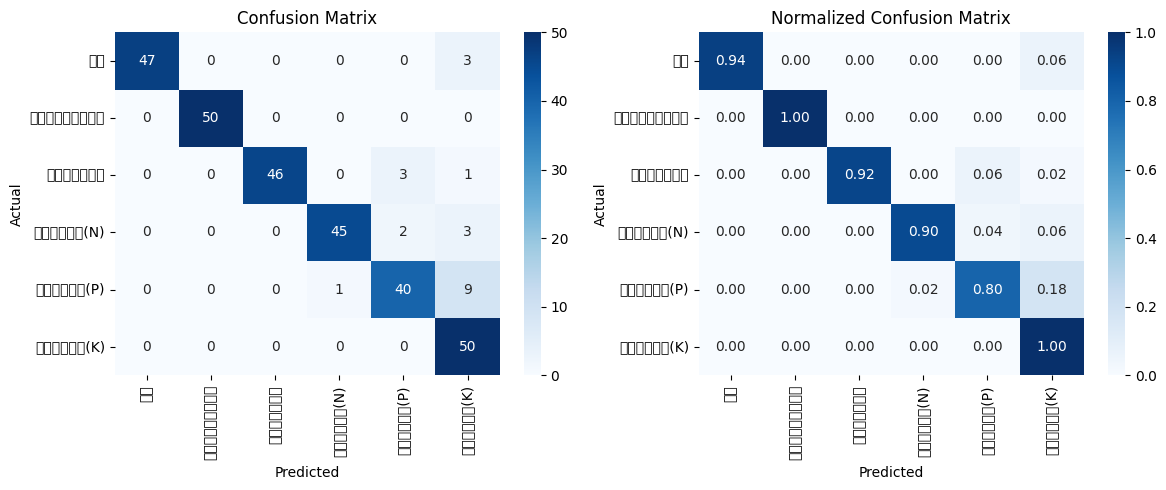

클래스별 주요 오분류:
  정상:
    → 다량원소결핍(K): 3개 (6.0%)
  토마토흰가루병:
    → 다량원소결핍(P): 3개 (6.0%)
    → 다량원소결핍(K): 1개 (2.0%)
  다량원소결핍(N):
    → 다량원소결핍(K): 3개 (6.0%)
    → 다량원소결핍(P): 2개 (4.0%)
  다량원소결핍(P):
    → 다량원소결핍(K): 9개 (18.0%)
    → 다량원소결핍(N): 1개 (2.0%)

=== 6. Top-K 정확도 ===
Top-1 정확도: 0.9267 (92.7%)
Top-2 정확도: 0.9633 (96.3%)
Top-3 정확도: 0.9867 (98.7%)

=== 7. 종합 성능 점수 ===
종합 성능 점수: 0.9018 (90.2%)
성능 등급: A급 (90-95%)

📋 최종 성능 요약:
  Overall Accuracy: 0.9267
  F1-Score (Macro): 0.9282
  Balanced Accuracy: 0.9267
  Cohen's Kappa: 0.9120
  Matthews CC: 0.9140
  Average Confidence: 0.7281
  Composite Score: 0.9018
  Performance Grade: A급 (90-95%)


({'Overall Accuracy': '0.9267',
  'F1-Score (Macro)': '0.9282',
  'Balanced Accuracy': '0.9267',
  "Cohen's Kappa": '0.9120',
  'Matthews CC': '0.9140',
  'Average Confidence': '0.7281',
  'Composite Score': '0.9018',
  'Performance Grade': 'A급 (90-95%)'},
 array([[47,  0,  0,  0,  0,  3],
        [ 0, 50,  0,  0,  0,  0],
        [ 0,  0, 46,  0,  3,  1],
        [ 0,  0,  0, 45,  2,  3],
        [ 0,  0,  0,  1, 40,  9],
        [ 0,  0,  0,  0,  0, 50]]),
 {'정상': {'precision': 1.0,
   'recall': 0.94,
   'f1-score': 0.9690721649484536,
   'support': 50.0},
  '토마토잿빛곰팡이병': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 50.0},
  '토마토흰가루병': {'precision': 1.0,
   'recall': 0.92,
   'f1-score': 0.9583333333333334,
   'support': 50.0},
  '다량원소결핍(N)': {'precision': 0.9782608695652174,
   'recall': 0.9,
   'f1-score': 0.9375,
   'support': 50.0},
  '다량원소결핍(P)': {'precision': 0.8888888888888888,
   'recall': 0.8,
   'f1-score': 0.8421052631578947,
   'support': 50.0},
 

In [ ]:
comprehensive_metrics_analysis()